In [9]:
#Loading files
import re
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

with open("books.yaml", "r") as f:
    yaml_data = yaml.safe_load(f)

cleaned_yaml = [{k.lstrip(":"): v for k, v in row.items()} for row in yaml_data]
df_books = pd.DataFrame(cleaned_yaml)

df_orders = pd.read_parquet("orders.parquet")

df_users = pd.read_csv("users.csv")

In [10]:
print("Books:")
df_books.head(5)

Books:


,id,title,author,genre,publisher,year
0,21778,Call of Duty: World at War,Elmer Parker,Mythopoeia,Orion Books,2003
1,21374,WarioWare: Touched!,Ms. Kami Prosacco,Mythology,St. Martin's Press,1951
2,21457,Titanic: Music from the Motion Picture,Zoila Christiansen,Historical fiction,"Farrar, Straus & Giroux",2009
3,21881,Flashdance: Original Soundtrack from the Motio...,"Joseph Raynor, Ja Ankunding II",Metafiction,Pen and Sword Books,2024
4,21446,Riot!,Louanne Cruickshank,Mystery,Bellevue Literary Press,1987


In [11]:
print("\nOrders:")
df_orders.head(5)


Orders:


,id,user_id,book_id,quantity,unit_price,timestamp,shipping
0,80941,47864,21550,1,67.0 €,2025-01-11 09:50:11 PM,
1,81245,47864,22052,2,EUR26.99,2024-03-27T07:46:55.055,
2,78477,48918,21367,1,30 $,"11:17:51 PM, 29-JUN-2025",
3,86303,48092,21724,1,18 $,09:29;11/06/24,None
4,81990,48418,21441,1,USD 24.99,2024-09-16;03:05:39 pm,None


In [12]:
print("\nUsers:")
df_users.head(5)


Users:


,id,name,address,phone,email
0,47856,Tammie Mayer,"Apt. 371 1875 Gusikowski Stravenue, Moenland, ...",163.212.2656,maire.larson@runolfsdottir-mclaughlin.example
1,49394,Evia Yost,"22610 Mildred Green, Pagacbury, AZ 19393-2103",778.926.6707,byron@johnston.test
2,48386,Margery Gorczany,"Apt. 884 349 Renner Lane, East Darren, NC 30837",992 375 5021,cletus@baumbach.test
3,49547,Edris Kshlerin,"Suite 498 24711 Bechtelar Extensions, Ryanvill...",747.537.2209,leonore@gleason.test
4,50512,Meghan Thiel,"125 Rodger Drive, Rogahnborough, VT 96988-4596",(631) 765-7676,cristine@bayer.test


In [13]:
print("Books info:")
print(df_books.info(), "\n")

print("Orders info:")
print(df_orders.info(), "\n")

print("Users info:")
print(df_users.info(), "\n")

print("Null values in Books:")
print(df_books.isna().sum(), "\n")

print("Null values in Orders:")
print(df_orders.isna().sum(), "\n")

print("Null values in Users:")
print(df_users.isna().sum(), "\n")


Books info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         762 non-null    int64 
 1   title      762 non-null    object
 2   author     762 non-null    object
 3   genre      762 non-null    object
 4   publisher  759 non-null    object
 5   year       760 non-null    object
dtypes: int64(1), object(5)
memory usage: 35.8+ KB
None 

Orders info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8933 entries, 0 to 8932
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          8933 non-null   int64 
 1   user_id     8933 non-null   int64 
 2   book_id     8933 non-null   int64 
 3   quantity    8933 non-null   int32 
 4   unit_price  8933 non-null   object
 5   timestamp   8933 non-null   object
 6   shipping    6721 non-null   object
dtypes: int32(1), int64(3), object(

In [14]:
#Data Cleaning for books.yaml
df_books["publisher"] = df_books["publisher"].fillna("unknown_publisher")

df_books["year"] = df_books["year"].fillna("unknown_year")

In [15]:
#Data Cleaning for users.csv
df_users["address"] = (
    df_users["address"]
    .replace(r"^\s*$", np.nan, regex=True)
    .fillna("unknown_address")
)

def normalize_phone(raw):
    if pd.isna(raw):
        return np.nan
    raw_str = str(raw).strip()
    digits = re.sub(r"\D", "", raw_str)
    return digits or np.nan

df_users["phone_norm"] = df_users["phone"].apply(normalize_phone)

In [16]:
#Data Cleaning for orders.parquet
formats = [
    "%Y-%m-%d,%H:%M",
    "%Y-%m-%d,%H:%M:%S",
    "%Y-%m-%d,%I:%M:%S %p",
    "%Y-%m-%dT%H:%M:%S",
    "%Y-%m-%dT%H:%M:%S.%f",
    "%d-%b-%Y,%H:%M",
    "%d-%b-%Y,%H:%M:%S",
    "%d-%b-%Y,%I:%M:%S %p",
    "%d-%B-%Y,%H:%M",
    "%d-%B-%Y,%H:%M:%S",
    "%d-%B-%Y,%I:%M:%S %p",
    "%H:%M,%Y-%m-%d",
    "%H:%M:%S,%Y-%m-%d",
    "%H:%M,%d-%b-%Y",
    "%H:%M:%S,%d-%b-%Y",
    "%H:%M,%d-%B-%Y",
    "%H:%M:%S,%d-%B-%Y",
    "%m/%d/%y,%H:%M",
    "%m/%d/%y,%H:%M:%S",
    "%m/%d/%y,%I:%M:%S %p",
    "%H:%M,%m/%d/%y",
    "%H:%M:%S,%m/%d/%y",
]

def clean_timestamp_str(s):
    if pd.isna(s):
        return None
    s = str(s).strip()
    s = s.replace(";", ",")
    s = re.sub(r"\s*,\s*", ",", s)
    s = (s.replace("A.M.", "AM")
           .replace("P.M.", "PM")
           .replace("a.m.", "AM")
           .replace("p.m.", "PM")
           .replace(" am", " AM")
           .replace(" pm", " PM"))
    return s

def parse_multi(s):
    s = clean_timestamp_str(s)
    if not s:
        return pd.NaT
    for fmt in formats:
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue
    try:
        return pd.to_datetime(s, errors="coerce", utc=False)
    except Exception:
        return pd.NaT

df_orders["timestamp_parsed"] = (
    df_orders["timestamp"]
    .apply(parse_multi)
    .pipe(pd.to_datetime, errors="coerce")
    .dt.floor("s")
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_20580\4283155357.py:51: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20580\4283155357.py:51: UserWarning: Parsing dates in %d-OCT-%Y %m:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20580\4283155357.py:51: UserWarning: Parsing dates in %I:%M:%d %p,%Y-%m-%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20580\4283155357.py:51: UserWarning: Parsing dates in %I:%d:%S %p,%Y-%m-%M fo

In [17]:
# Checking parsed dates
total = len(df_orders)
bad = df_orders["timestamp_parsed"].isna().sum()
print("All records:", total)
print("Unparsed dates:", bad)
print("Share unparsed:", round(bad / total, 3))
print("Sample bad values:")
print(df_orders.loc[df_orders["timestamp_parsed"].isna(), "timestamp"].unique()[:20])

print("Min date:", df_orders["timestamp_parsed"].min())
print("Max date:", df_orders["timestamp_parsed"].max())

print("Date type:", df_orders["timestamp_parsed"].dtype)

All records: 8933
Unparsed dates: 0
Share unparsed: 0.0
Sample bad values:
[]
Min date: 2024-01-04 00:18:18
Max date: 2025-12-05 01:25:25
Date type: datetime64[ns]


In [18]:
#Checking values for shipping
shipping_raw = df_orders["shipping"].astype(str).str.strip()

print("Sample unique values:")
print(shipping_raw.unique()[:10])

print("Value counts (top 5):")
print(shipping_raw.value_counts().head(5))

Sample unique values:
['' 'None' 'NULL' '605 Durgan Corner, New Marcos, PA 20319-6778'
 'Suite 772 5259 Ozie Summit, Cummerataview, IN 87860'
 '78346 Edmundo Heights, Huelshire, VA 41518-0607'
 '70939 Lloyd Fall, Dooleybury, CO 89886'
 'Suite 852 6071 Frami Grove, Lake Refugiofurt, MI 42887'
 '7358 Syreeta Prairie, New Pamelabury, DE 91542'
 'Suite 969 7846 Rocio Rue, Dachchester, HI 26095-4420']
Value counts (top 5):
shipping
                                                            2261
None                                                        2212
NULL                                                        2188
Apt. 655 62881 Prosacco Isle, Goyetteport, OH 74479-9133       6
1505 Greenfelder Fall, West Stephanbury, MI 11548              6
Name: count, dtype: int64


In [19]:
# Clean up shipping values
empty_tokens = {"", "None", "NULL", "null", "none"}

df_orders["shipping"] = (
    df_orders["shipping"]
    .astype(str)
    .str.strip()
    .replace({val: np.nan for val in empty_tokens})
)

print("NaN in shipping:", df_orders["shipping"].isna().sum())
print("Example non-null values:")
print(df_orders.loc[df_orders["shipping"].notna(), "shipping"].unique()[:20])

NaN in shipping: 6661
Example non-null values:
['605 Durgan Corner, New Marcos, PA 20319-6778'
 'Suite 772 5259 Ozie Summit, Cummerataview, IN 87860'
 '78346 Edmundo Heights, Huelshire, VA 41518-0607'
 '70939 Lloyd Fall, Dooleybury, CO 89886'
 'Suite 852 6071 Frami Grove, Lake Refugiofurt, MI 42887'
 '7358 Syreeta Prairie, New Pamelabury, DE 91542'
 'Suite 969 7846 Rocio Rue, Dachchester, HI 26095-4420'
 'Apt. 429 33804 Kathryn Mountains, Joanaburgh, MA 37568-5100'
 'Apt. 659 83330 Schmeler Lodge, Napoleonborough, CO 90847-5961'
 'Apt. 325 62226 Friesen Crossing, Douglaschester, WA 60351'
 'Suite 229 8016 Clifton Mission, East Ianburgh, OR 94196-5070'
 'Suite 539 278 Lida Rapids, Lake Coltonport, IA 27687-9720'
 'Suite 134 64019 Jon Corners, North Alonaport, NV 81038-7338'
 'Suite 220 77811 Davis Plaza, Port Lisaport, IL 97878'
 '225 Carolann Passage, West Anderson, WI 01900'
 '56199 Jamey Shoals, Lake Issacville, VT 17712'
 '4469 White Manor, Carsonberg, AK 60694-6854'
 'Apt. 192 969 

In [20]:
# Parsing prices in orders.parquet

df_orders["unit_price_raw"] = df_orders["unit_price"].astype(str)

df_orders["currency"] = np.where(
    df_orders["unit_price_raw"].str.contains("€|EUR", case=False, na=False),
    "EUR",
    "USD"
)

def parse_price(text: str) -> float:
    s = str(text).strip()

    nums = re.findall(r"\d+", s)

    if ("¢" in s or "$" in s) and "." not in s and len(nums) >= 2:
        dollars = int(nums[0])
        cents = int(nums[1])
        return dollars + cents / 100

    cleaned = re.sub(r"[^\d.]", "", s)
    if cleaned == "":
        return np.nan

    try:
        return float(cleaned)
    except ValueError:
        return np.nan

df_orders["unit_price"] = df_orders["unit_price_raw"].apply(parse_price)

In [21]:
# Change EURO to USD in df_orders
eur_to_usd = 1.2

df_orders["unit_price"] = np.where(
    df_orders["currency"] == "EUR",
    df_orders["unit_price"] * eur_to_usd,
    df_orders["unit_price"]
)

In [22]:
# Add column paid_price in df_orders
df_orders["paid_price"] = df_orders["quantity"] * df_orders["unit_price"]

In [23]:
# Add date column in df_orders

df_orders["date"] = df_orders["timestamp_parsed"].dt.date

df_orders["date"] = pd.to_datetime(
    df_orders["date"],
    format="%Y-%m-%d",
    errors="coerce"
)

In [24]:
# 1. Compute daily revenue (sum of paid_price grouped by date) and find top 5 days by revenue.
daily_revenue = df_orders.groupby("date")["paid_price"].sum().reset_index()
top_5_days = daily_revenue.sort_values(by="paid_price", ascending=False).head(5)

In [25]:
# 2. Find how many real unique users there are. Note that user can change address or change phone or even provide alias instead of a real name;
# you need to reconciliate data. You may assume that only one field is changed.

df_clean = df_users.copy().reset_index(drop=True)

cols = ["name", "address", "phone_norm", "email"]
for c in cols:
    df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

df_clean["k1"] = df_clean["name"]    + "|" + df_clean["address"]    + "|" + df_clean["phone_norm"]
df_clean["k2"] = df_clean["name"]    + "|" + df_clean["address"]    + "|" + df_clean["email"]
df_clean["k3"] = df_clean["name"]    + "|" + df_clean["phone_norm"] + "|" + df_clean["email"]
df_clean["k4"] = df_clean["address"] + "|" + df_clean["phone_norm"] + "|" + df_clean["email"]

n = len(df_clean)
parent = np.arange(n)

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

key_cols = ["k1", "k2", "k3", "k4"]

for col in key_cols:
    for key, group in df_clean.groupby(col):
        idx = group.index.to_list()
        if len(idx) > 1:
            first = idx[0]
            for i in idx[1:]:
                union(first, i)

roots = np.array([find(i) for i in range(n)])

df_users["global_id"] = pd.factorize(roots)[0]
num_unique_users = len(df_users["global_id"].unique())


print("All records:", len(df_users))
print("Unique users:", num_unique_users)

All records: 3466
Unique users: 3290


In [26]:
# 3. Find how how many unique sets of authors there are.
# For example, if John and Paul wrote a book together and wrote several books separately, it means that there are 3 different sets.
def author_set(s):
    if pd.isna(s):
        return tuple()
    authors = [a.strip() for a in str(s).split(",")]
    authors = [a for a in authors if a]
    return tuple(sorted(set(authors)))

df_books["author_set"] = df_books["author"].apply(author_set)

num_unique_author_sets = df_books["author_set"].nunique()

print("All records:", len(df_books))
print("Unique sets of authors:", num_unique_author_sets)

All records: 762
Unique sets of authors: 268


In [27]:
# 4. Find the most popular (by sold book count) author (or author set).
sales_per_book = (
    df_orders
    .groupby("book_id")["quantity"] 
    .sum()
    .rename("total_sold")
    .reset_index()
)

df_book_sales = df_books.merge(
    sales_per_book,
    left_on="id",
    right_on="book_id",
    how="left"
)

df_book_sales["total_sold"] = df_book_sales["total_sold"].fillna(0)

sales_per_author_set = (
    df_book_sales
    .groupby("author_set", as_index=False)[["total_sold"]]
    .sum()
    .sort_values("total_sold", ascending=False)
)

most_popular_set = sales_per_author_set.head(1)

best_author = most_popular_set["author_set"].iloc[0]
best_sold = most_popular_set["total_sold"].iloc[0]
print("Most popular author set:", best_author)
print("Total sold:", best_sold)

Most popular author set: ('Coy Streich', 'Keeley Hand', 'Lela Emard')
Total sold: 159


In [28]:
# 5. Best buyer (with aliases) as an array of ids ([id1, id2, ...])

df_orders_mapped = df_orders.merge(
    df_users[["id", "global_id"]],
    left_on="user_id",
    right_on="id",
    how="left"
)

spend_per_person = (
    df_orders_mapped
    .groupby("global_id")["paid_price"]
    .sum()
    .rename("total_spent")
)

max_spent = spend_per_person.max()

best_global_ids = spend_per_person[spend_per_person == max_spent].index.to_list()

aliases_per_person = (
    df_users
    .groupby("global_id")["id"]
    .apply(lambda s: sorted(set(s)))
)

best_buyer_aliases = {
    gid: aliases_per_person.loc[gid]
    for gid in best_global_ids
}

best_ids_flat = sorted({i for ids in best_buyer_aliases.values() for i in ids})

print("Best buyer global_ids:", best_global_ids)
print("Best buyer aliases:", best_ids_flat)


Best buyer global_ids: [522]
Best buyer aliases: [49715, 50963]


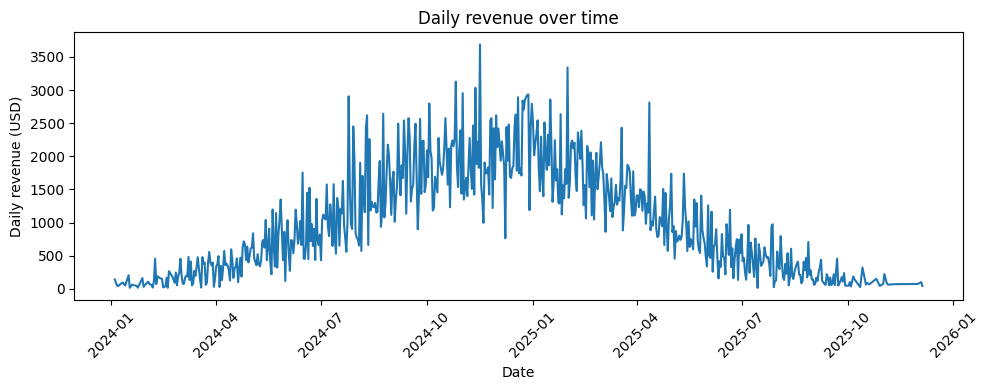

In [29]:
# 6.Plot a simple line chart of daily revenue using matplotlib.
daily_revenue = (
    df_orders
    .groupby("date")["paid_price"]
    .sum()
    .rename("revenue")
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(daily_revenue["date"], daily_revenue["revenue"])
plt.xlabel("Date")
plt.ylabel("Daily revenue (USD)")
plt.title("Daily revenue over time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("daily_revenue.png", dpi=300)
plt.show()

In [30]:
# Showing all the results

# 1.Top 5 days by revenue (YYYY-MM-dd)
print("Top 5 days by revenue (YYYY-MM-dd):")
print(top_5_days, "\n")

# 2.Number of unique users
print("Number of unique users:")
print("All records:", len(df_users))
print("Unique users:", num_unique_users, "\n")

# 3.Number of unique sets of authors
print("Number of unique sets of authors:")
print("All records:", len(df_books))
print("Unique sets of authors:", num_unique_author_sets, "\n")

# 4.Name of most popular author(s)
print("Most popular author(s), by sold book count:" "\n", best_author, best_sold, "\n")

# 5.Best buyer (with aliases) as an array of ids ([id1, id2, ...])
print("Best buyer id(s):", best_ids_flat)

Top 5 days by revenue (YYYY-MM-dd):
          date  paid_price
295 2024-11-16    3688.192
371 2025-01-31    3341.980
274 2024-10-26    3127.920
291 2024-11-12    3034.540
280 2024-11-01    2954.020 

Number of unique users:
All records: 3466
Unique users: 3290 

Number of unique sets of authors:
All records: 762
Unique sets of authors: 268 

Most popular author(s), by sold book count:
 ('Coy Streich', 'Keeley Hand', 'Lela Emard') 159 

Best buyer id(s): [49715, 50963]


In [31]:
# 1) Top 5 days by revenue
df_top_days = top_5_days.copy()

# 2) Number of unique users
df_unique_users_summary = pd.DataFrame([{
    "all_records": len(df_users),
    "unique_users": num_unique_users,
}])

# 3) Number of unique sets of authors
df_unique_author_sets_summary = pd.DataFrame([{
    "all_records": len(df_books),
    "unique_sets_of_authors": num_unique_author_sets,
}])

# 4) Most popular author(s) – obsługa wielu autorów
if isinstance(best_author, tuple):
    authors = list(best_author)
elif isinstance(best_author, list):
    authors = best_author
else:
    authors = [best_author]

df_top_authors = pd.DataFrame(
    [{"author": a, "sold_book_count": best_sold} for a in authors]
)

# 5) Best buyer id(s)
df_best_buyers = pd.DataFrame({
    "buyer_id": best_ids_flat
})

with pd.ExcelWriter("data_summary_3.xlsx") as writer:
    df_top_days.to_excel(writer, sheet_name="top5_days_by_revenue", index=False)
    df_unique_users_summary.to_excel(writer, sheet_name="unique_users_summary", index=False)
    df_unique_author_sets_summary.to_excel(writer, sheet_name="unique_author_sets_authors", index=False)
    df_top_authors.to_excel(writer, sheet_name="top_authors_by_sold_books", index=False)
    df_best_buyers.to_excel(writer, sheet_name="best_buyer_ids", index=False)